In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA

Najlepsze parametry dla Regresji Logistycznej:
{'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__max_iter': 1000}

Wyniki Regresji Logistycznej:
              precision    recall  f1-score   support

         0.0       1.00      0.04      0.07        28
         1.0       0.85      1.00      0.92       150

    accuracy                           0.85       178
   macro avg       0.92      0.52      0.49       178
weighted avg       0.87      0.85      0.78       178


Najlepsze parametry dla KNN:
{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}

Wyniki KNN:
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78        28
         1.0       0.95      0.97      0.96       150

    accuracy                           0.93       178
   macro avg       0.88      0.86      0.87       178
weighted avg       0.93      0.93      0.93       178



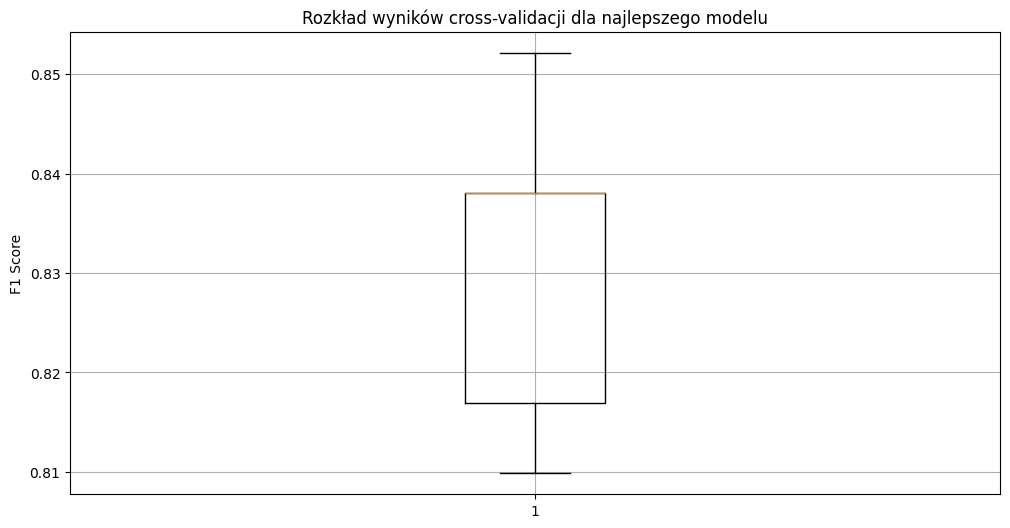

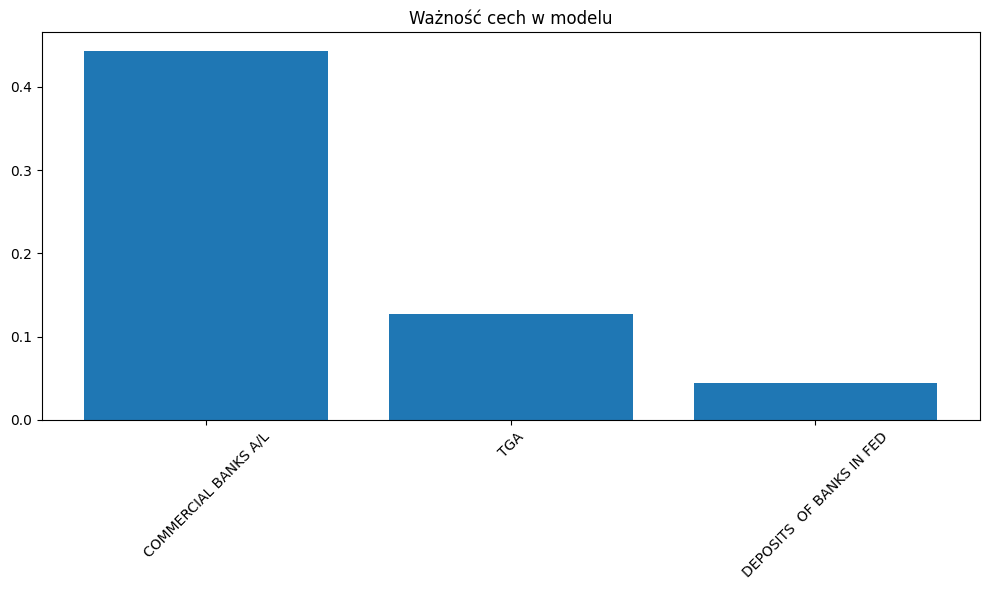

In [6]:

# Wczytanie danych
data = pd.read_excel("C:/Users/wkaco/Desktop/iobr.xlsx")
data["SPREAD_SOFR"] = (data["EFFR"] - data['SOFR'] > 0).astype(int)

# Interpolacja i przygotowanie danych
columns_to_interpolate = ["TGA", "DEPOSITS  OF BANKS IN FED", "COMMERCIAL BANKS A/L"]
for col in columns_to_interpolate:
    data[col] = data[col].interpolate()

sofr = data["SPREAD_SOFR"]
features = data[columns_to_interpolate]

# Obliczenie procentowych zmian
X = features.pct_change().dropna()
y = pd.DataFrame(sofr.shift(1).dropna())

# Dopasowanie długości
min_length = min(len(X), len(y))
X = X.iloc[:min_length]
y = y.iloc[:min_length]

# Podział danych z większym zbiorem treningowym
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Przygotowanie pipeline'u dla Regresji Logistycznej
log_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),  # Zmniejszono proporcję oversampleowania
    ('classifier', LogisticRegression())
])

# Parametry do optymalizacji dla Regresji Logistycznej
log_param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__max_iter': [1000],
    'classifier__class_weight': ['balanced', None]
}

# Grid Search dla Regresji Logistycznej
log_grid = GridSearchCV(
    log_pipeline,
    log_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

log_grid.fit(X_train, y_train.values.ravel())
log_predictions = log_grid.predict(X_test)

print("Najlepsze parametry dla Regresji Logistycznej:")
print(log_grid.best_params_)
print("\nWyniki Regresji Logistycznej:")
print(classification_report(y_test, log_predictions))

# Przygotowanie pipeline'u dla KNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
    ('classifier', KNeighborsClassifier())
])

# Parametry do optymalizacji dla KNN
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Grid Search dla KNN
knn_grid = GridSearchCV(
    knn_pipeline,
    knn_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

knn_grid.fit(X_train, y_train.values.ravel())
knn_predictions = knn_grid.predict(X_test)

print("\nNajlepsze parametry dla KNN:")
print(knn_grid.best_params_)
print("\nWyniki KNN:")
print(classification_report(y_test, knn_predictions))

# Wizualizacja wyników cross-validacji
plt.figure(figsize=(12, 6))
scores = cross_val_score(log_grid.best_estimator_, X_train, y_train.values.ravel(), cv=5)
plt.boxplot(scores)
plt.title('Rozkład wyników cross-validacji dla najlepszego modelu')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

# Wykres ważności cech dla Regresji Logistycznej
best_log_model = log_grid.best_estimator_.named_steps['classifier']
feature_importance = pd.DataFrame({
    'feature': columns_to_interpolate,
    'importance': np.abs(best_log_model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Ważność cech w modelu')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()